In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
from os.path import join
from glob import glob
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
from bayeshist import bayesian_histogram, plot_bayesian_histogram
import matplotlib.pyplot as plt


from display_names import to_readable_names, get_units
from load_explain_data import load_explain
from probsr_config import PREDICTOR_COLUMNS, FIGURE_MAPPINGS, COLOR_DICT, UNITS, TARGET_COLUMN

In [2]:
hazards = ['tornado', 'severe_hail', 'severe_wind', 'road_surface']

datasets = {}

for hazard in hazards:
    if hazard != 'road_surface':
        # Load the WoFS data. 
        base_path = '/work/mflora/ML_DATA/DATA'
        data_path = join(base_path, f'original_first_hour_training_matched_to_{hazard}_0km_data.feather')
        df = pd.read_feather(data_path)

        # Load the WoFS-ML-Severe Models
        base_path = '/work/mflora/ML_DATA/MODEL_SAVES'
        model_name = 'LogisticRegression'
        model_paths = glob(join(base_path, f'{model_name}_first_hour_{hazard}*'))
        model_path = [m for m in model_paths if 'manual' not in m][0]
        model_data = joblib.load(model_path)

        model = model_data['model']
        feature_names = model_data['features']

        X = df[feature_names].astype(float)
        y = df[f'matched_to_{hazard}_0km'].astype(float)

    else:
        df = pd.read_csv('/work/mflora/ROAD_SURFACE/probsr_training_data.csv')
        X = df[PREDICTOR_COLUMNS].astype(float)
        y = df[TARGET_COLUMN]
        
    datasets[hazard] = {'X' : X, 'y' : y}    

In [3]:
display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}
display_units = {**display_units, **UNITS }

In [4]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]
    
    inds = np.digitize(feature_vals, bins=bins)
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [5]:
results = {}
hazards = ['tornado', 'severe_hail', 'severe_wind','road_surface']
for hazard in hazards:
    ale, _, shap_vals, X_shap, pd = load_explain(hazard, feature_names, return_pd=True)
    results[hazard] = {'ale' : ale, 
                       'shap' : shap_vals, 
                       'X' : X_shap, 
                       'pd': pd, 
                      }

In [6]:
feature_names

['srh_0to1_ens_mean_spatial_mean',
 'srh_0to3_ens_mean_spatial_mean',
 'cape_ml_ens_mean_spatial_mean',
 'cin_ml_ens_mean_spatial_mean',
 'shear_u_0to6_ens_mean_spatial_mean',
 'shear_v_0to6_ens_mean_spatial_mean',
 'shear_u_0to1_ens_mean_spatial_mean',
 'shear_v_0to1_ens_mean_spatial_mean',
 'lcl_ml_ens_mean_spatial_mean',
 'th_e_ml_ens_mean_spatial_mean',
 'u_10_ens_mean_spatial_mean',
 'v_10_ens_mean_spatial_mean',
 'mid_level_lapse_rate_ens_mean_spatial_mean',
 'low_level_lapse_rate_ens_mean_spatial_mean',
 'temperature_850mb_ens_mean_spatial_mean',
 'temperature_700mb_ens_mean_spatial_mean',
 'temperature_500mb_ens_mean_spatial_mean',
 'geopotential_height_850mb_ens_mean_spatial_mean',
 'geopotential_height_700mb_ens_mean_spatial_mean',
 'geopotential_height_500mb_ens_mean_spatial_mean',
 'dewpoint_850mb_ens_mean_spatial_mean',
 'dewpoint_700mb_ens_mean_spatial_mean',
 'dewpoint_500mb_ens_mean_spatial_mean',
 'uh_0to2_time_max_ens_mean_spatial_mean',
 'uh_2to5_time_max_ens_mean_sp

overflow encountered in exp
overflow encountered in exp


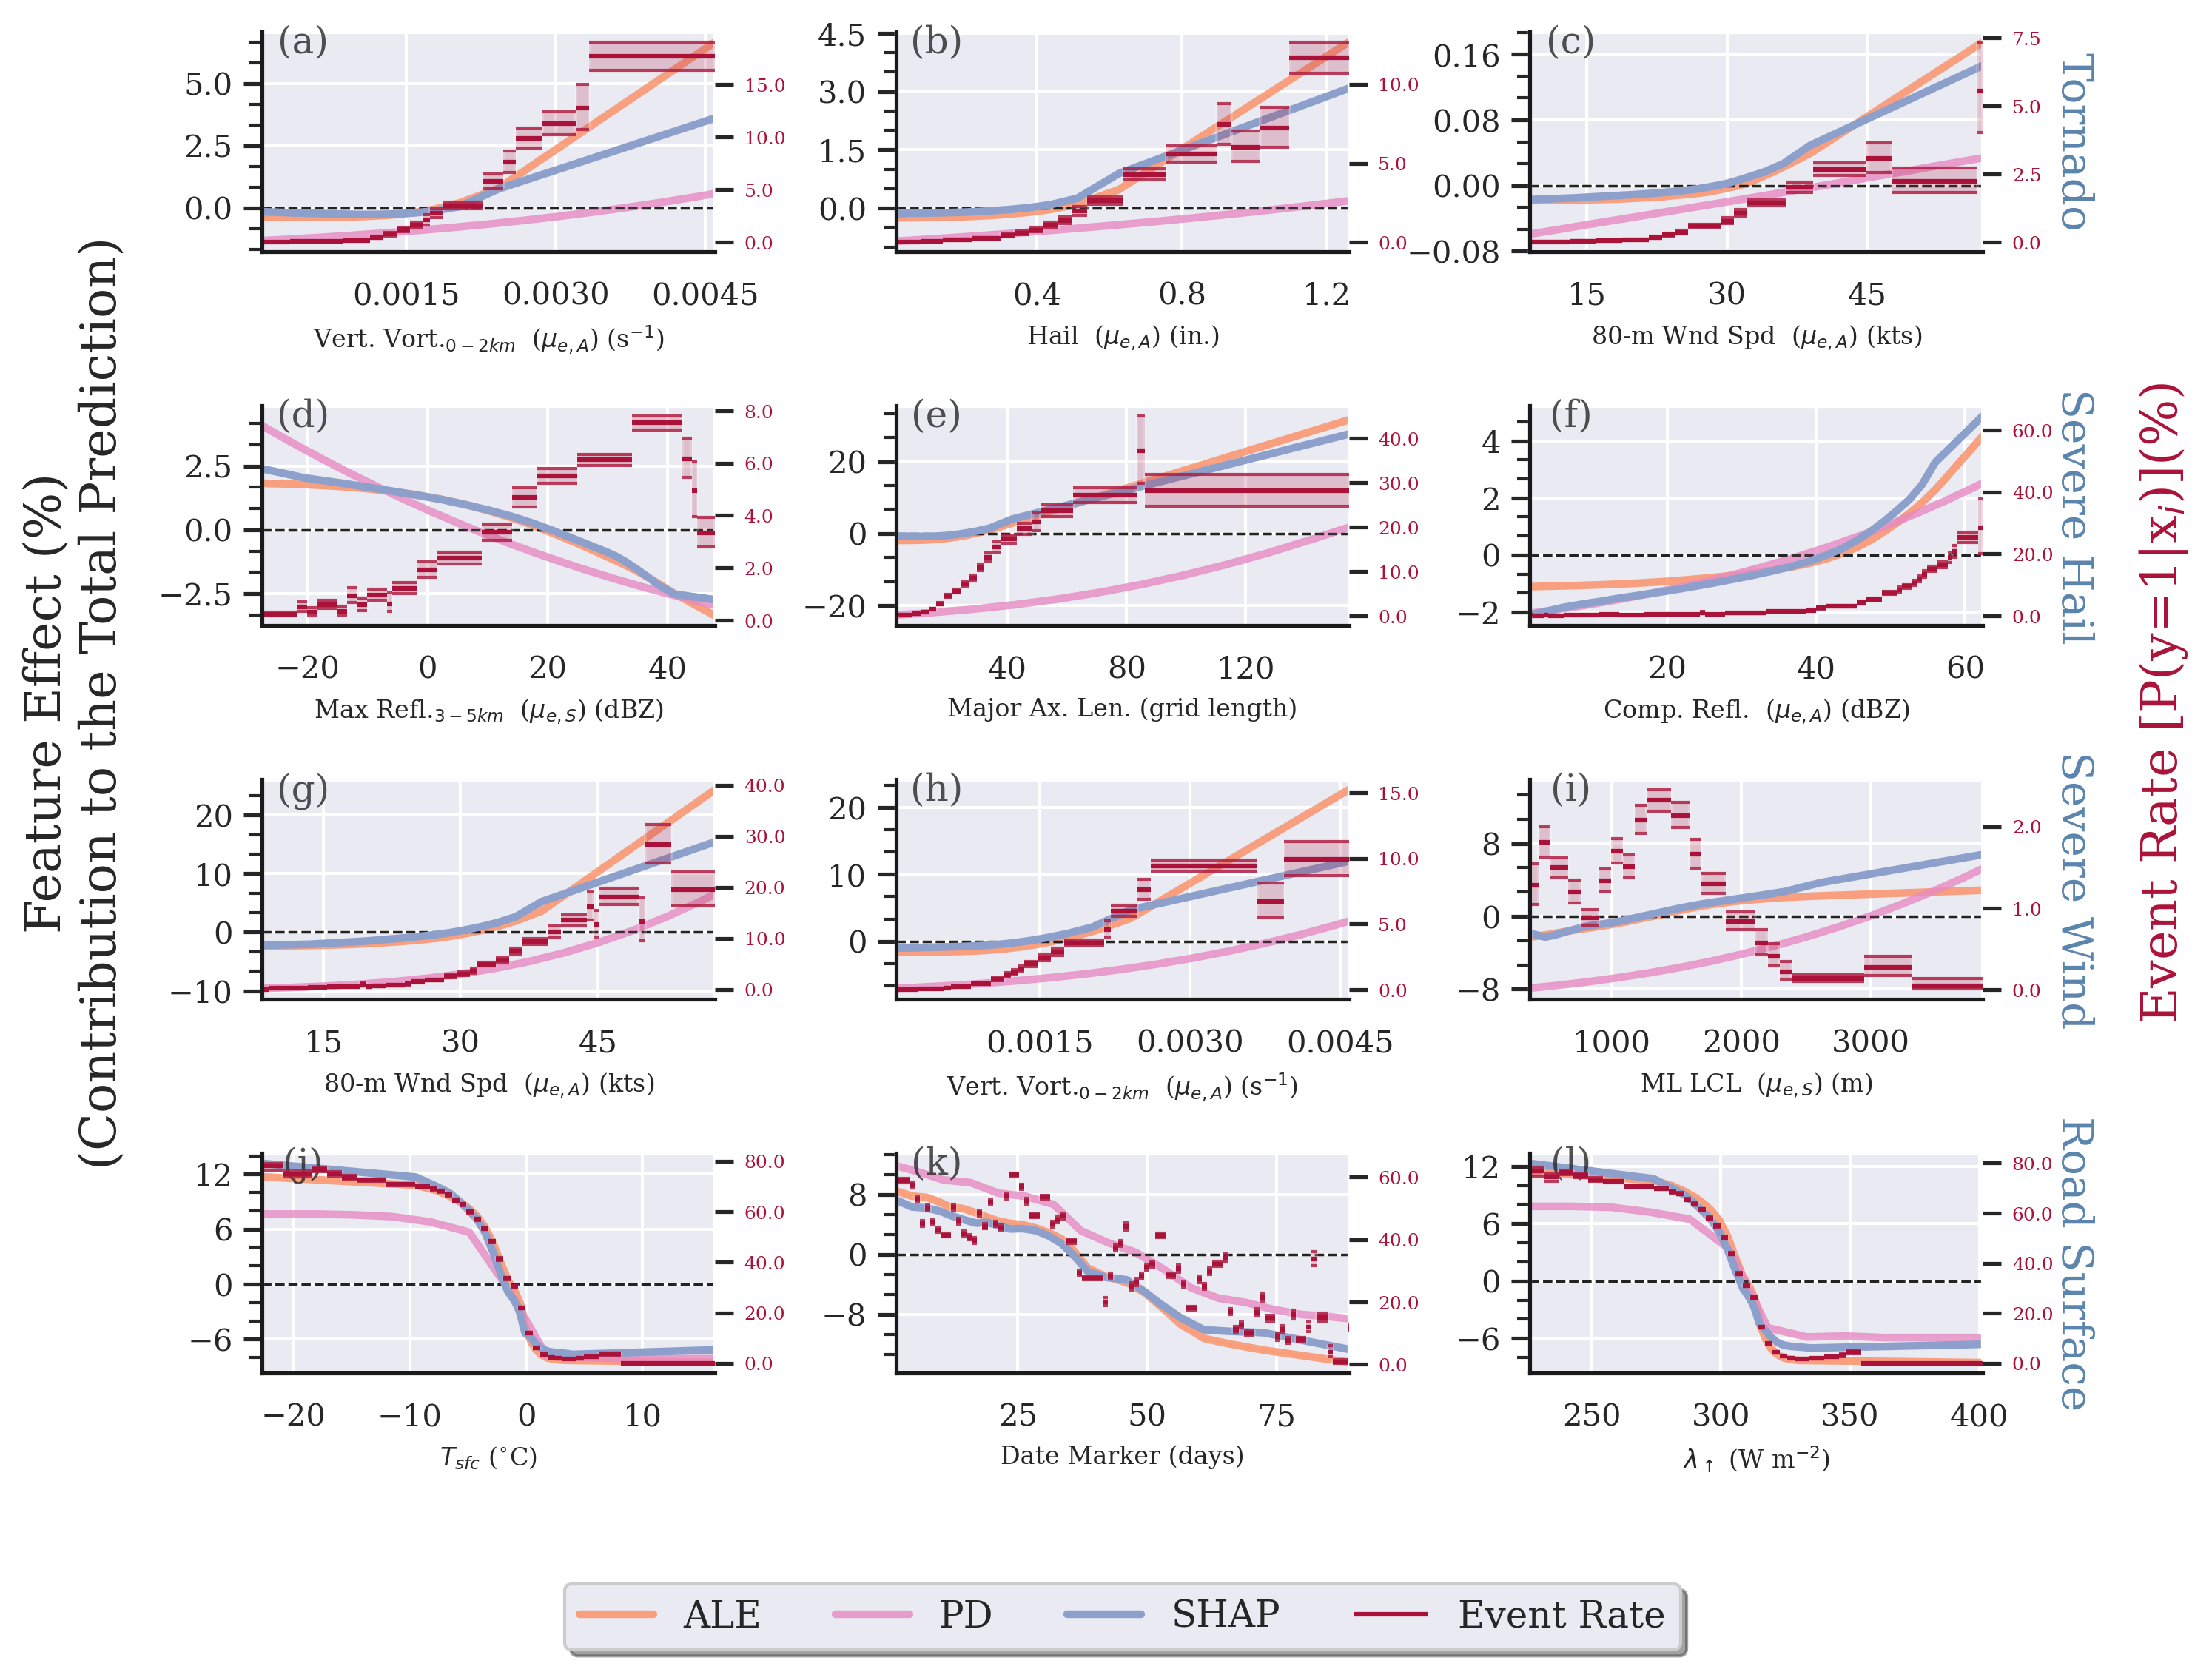

In [7]:
explainer = skexplain.ExplainToolkit(X=X,y=y)

from matplotlib.ticker import MaxNLocator
estimator_name = 'LogisticRegression'

features_dict = {'tornado': 
                ['wz_0to2_time_max_ens_mean_of_90th',
                 'hailcast_time_max_ens_mean_of_90th', 
                 'ws_80_time_max_ens_mean_of_90th', 
               ], 
                 
              'severe_hail': ['dbz_3to5km_max_time_max_ens_mean_spatial_mean',
                              'major_axis_length', 
                              'comp_dz_time_max_ens_mean_of_90th', ],
                 
            'severe_wind' : ['ws_80_time_max_ens_mean_of_90th', 
                             'wz_0to2_time_max_ens_mean_of_90th',
                             'lcl_ml_ens_mean_spatial_mean', ],
                 
            'road_surface': ['sfc_temp', 'date_marker', 'uplwav_flux'], 
                }
plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, axes = plotter.create_subplots(n_panels=12, n_columns=3, figsize=(10,8), dpi=300, 
                                      wspace=0.4, hspace=0.35)

hazards_ = [hazards[0]]*3 + [hazards[1]]*3 + [hazards[2]]*3 + [hazards[-1]]*3            
            
features=[]                
for hazard in hazards:
     features.extend(features_dict[hazard])            
            
for ax in axes.flat:
    ax.grid()
    
colors = list(sns.color_palette("Set2"))
for ax, feature, hazard in zip(axes.flat, features, hazards_):
    ale_results, shap_vals, X_shap= results[hazard]['ale'], results[hazard]['shap'], results[hazard]['X']       
    pd_results = results[hazard]['pd']
    
    X,y = datasets[hazard]['X'], datasets[hazard]['y']
    
    name = 'LogisticRegression' if hazard != 'road_surface' else 'Random Forest'
    
    # Plot the ALE curve. 
    explainer.plot_ale(ale_results, 
                   features = [feature],
                   estimator_names = [name],
                   add_hist=False, 
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   ax=ax, line_kws = {'line_colors' : [colors[1]], 'linewidth': 2.5}, 
                   to_probability=True,
                      )
    
    # Plot the PD curve. 
    explainer.plot_pd(pd_results, 
                   features = [feature],
                   estimator_names = [name],
                   add_hist=False, 
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   ax=ax, line_kws = {'line_colors' : [colors[3]], 'linewidth': 2.5}, 
                   to_probability=True,
                      )

    # Plot the SHAP mean curve. 
    bin_values = ale_results[f'{feature}__bin_values'].values
    shap_mean = shap_to_curve(feature, shap_vals, X_shap, bin_values)
    ax.plot(bin_values, shap_mean*100., linewidth=2.5, color=colors[2], label='SHAP')
    
    handles, labels = ax.get_legend_handles_labels()
    
    # Compute RMSE between ALE and mean SHAP. 
    ale_data = ale_results[f'{feature}__{name}__ale'].values
    rmse = np.sqrt(np.mean((shap_mean - ale_data)**2))
    
    #txt = f'RMSE(ALE, SHAP): {rmse:.2e}'
    #ax.annotate(txt, xy=(0.05, 0.8), xycoords='axes fraction', fontsize=8)
    
    #ax.yaxis.set_major_locator(MaxNLocator(interger=True))

    # plot it up
    data = X[feature].values.astype(float)
    bin_edges, beta_dist = bayesian_histogram(data, y)

    ax_twin = plotter.make_twin_ax(ax)
    ax_twin.set_zorder(ax.get_zorder() + 1)
    ax_twin.patch.set_visible(False)
    ax.patch.set_visible(True)
    ax.grid()
    sns.despine(ax=ax_twin)
    for spine in ax_twin.spines.values():
        spine.set_edgecolor('k')
    plot_bayesian_histogram(bin_edges, beta_dist, ax=ax_twin, color = 'xkcd:rouge', label='Event Rate')

    #ax_twin.set_ylim([-0.05, 0.3])
    ylabels = ax_twin.get_yticklabels()
    
    [label.set_color('xkcd:rouge') for label in ylabels]
    ax_twin.set_yticklabels(np.round(ax_twin.get_yticks()*100., 1))
    
    h, l = ax_twin.get_legend_handles_labels()
    
    ax.set_xlim([bin_values.min(), bin_values.max()])
    plotter.set_n_ticks(ax, nticks=4, option="both")
    plotter.set_minor_ticks(ax)
    
    
major_ax = plotter.set_major_axis_labels(fig, 
                              xlabel=None, 
                              ylabel_left='Feature Effect (%)\n(Contribution to the Total Prediction)', 
                              ylabel_right='Event Rate [P(y=1|x$_{i}$)](%)', title=None,
                              ylabel_right_color = 'xkcd:rouge',
                              labelpad=25, 
    )    
    
plotter.set_legend(12, fig, ax, major_ax, 
                   handles=handles+h, labels=['ALE', 'PD', 'SHAP', 'Event Rate'],
                   bbox_to_anchor = (0.5, -0.22), ncol=4, fontsize=12,
                  )

plotter.add_alphabet_label(12, axes, pos=(0.09, 0.95), alphabet_fontsize=12)

labels = [h.replace('_', ' ').title() for h in hazards]

plotter.set_row_labels(labels, axes, pos=-1, pad=1.20, rotation=270)

plt.subplots_adjust(hspace=0.7)